In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.utils import resample
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud
from collections import Counter


from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense,Flatten,Dropout
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [4]:
df=pd.read_csv("/content/SPAM text message 20170820 - Data.csv")

In [5]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
df["Message"]

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object

In [7]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

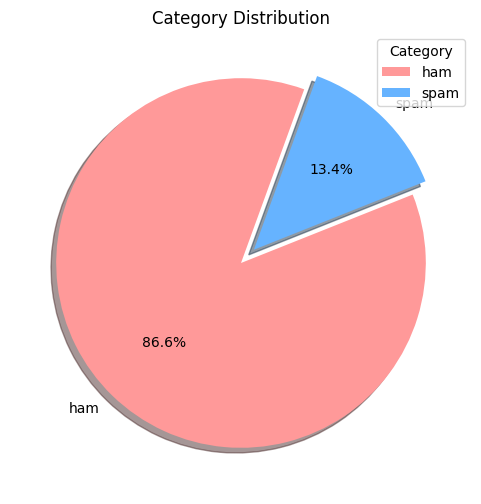

In [8]:
plt.figure(figsize=(6,6))
colors = ['#ff9999', '#66b3ff']
explode = (0, 0.1)
plt.pie(x=df['Category'].value_counts().values, labels=['ham', 'spam'],
        autopct='%.1f%%', startangle=70, explode=explode, colors=colors, shadow=True)
plt.legend(title="Category", loc="upper right")
plt.title("Category Distribution")
plt.show()

**unbalancing data**

**how to balance data**

In [9]:
ham_msg = df[df.Category == "ham"]
spam_msg = df[df.Category == 'spam']

In [10]:
ham_downsample = resample(ham_msg,
             replace=True,
             n_samples=len(spam_msg),
             random_state=42)

In [11]:
data = pd.concat([ham_downsample, spam_msg])

In [12]:
data

,Category,Message
1014,ham,Just buy a pizza. Meat lovers or supreme. U ge...
4364,ham,Evry Emotion dsn't hav Words.Evry Wish dsn't h...
3570,ham,She's fine. Sends her greetings
546,ham,Then any special there?
5121,ham,"Oops I did have it, &lt;#&gt; ?"
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [13]:
data["Category"].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

<ipython-input-14-1d45129d84a8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = data['Category'].unique(), y = data['Category'].value_counts(), palette= 'viridis')


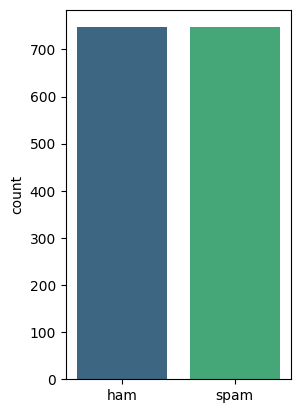

In [14]:
plt.subplot(1, 2, 2)
sns.barplot(x = data['Category'].unique(), y = data['Category'].value_counts(), palette= 'viridis')

plt.show()

# **preprocessing text**

In [15]:
data

,Category,Message
1014,ham,Just buy a pizza. Meat lovers or supreme. U ge...
4364,ham,Evry Emotion dsn't hav Words.Evry Wish dsn't h...
3570,ham,She's fine. Sends her greetings
546,ham,Then any special there?
5121,ham,"Oops I did have it, &lt;#&gt; ?"
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


**lowercase all data**

In [16]:
print(data["Message"].iloc[2])
def convert_lowercase(text):
    text = text.lower()
    return text

data['Message'] = data['Message'].apply(convert_lowercase)

data["Message"].iloc[2]

She's fine. Sends her greetings


"she's fine. sends her greetings"

**removing URL**

In [17]:
print(data["Message"].iloc[8])
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['Message'] = data['Message'].apply(remove_url)
data["Message"].iloc[8]

aaooooright are you at work?


'aaooooright are you at work?'

**removing all punctuation**

In [18]:
print(data["Message"].iloc[6])
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

data['Message']= data['Message'].apply(lambda x: remove_punctuations(x))
data["Message"].iloc[6]

wait.i will come out.. &lt;#&gt;  min:)


'waiti will come out ltgt  min'

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**removing stopwords**

In [20]:
print(data["Message"].iloc[12])
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


data['Message'] = data['Message'].apply(lambda text: remove_stopwords(text))
data["Message"].iloc[12]

genius whats up how your brother pls send his number to my skype


'genius whats brother pls send number skype'

**removing all digits**

In [21]:
print(data["Message"].iloc[-5])
data['Message'] = data['Message'].apply(lambda x:re.sub('[\d]','',x))
data["Message"].iloc[-5]

want explicit sex 30 secs ring 02073162414 costs 20pmin gsex pobox 2667 wc1n 3xx


'want explicit sex  secs ring  costs pmin gsex pobox  wcn xx'

In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**stemming or lemmatization**

In [23]:
print(data["Message"].iloc[2])
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['Message'] = data['Message'].apply(perform_stemming)
data["Message"].iloc[2]

shes fine sends greetings


'she fine send greet'

# **EDA**

**frequent words in spam email**

In [24]:
all_spam_words = []
for sentence in data[data['Category'] == "spam"]['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
df = pd.DataFrame(Counter(all_spam_words).most_common(50), columns= ['Word', 'Frequency'])
df.style.background_gradient(cmap='Purples')

,Word,Frequency
0,call,365
1,£,267
2,free,219
3,txt,163
4,u,154
5,ur,144
6,text,139
7,mobil,136
8,stop,118
9,claim,113


In [25]:
fig = px.treemap(df, path=['Word'], values='Frequency', title='Tree of Most Common Words', color='Frequency')
fig.show()

In [26]:
fig = px.bar(
    df,
    x="Frequency",
    y="Word",
    title='Common Words in SPAM',
    width=700,
    height=700,
    color='Frequency',  # Set the color based on the count of common words
    color_continuous_scale='YlGnBu',  # Specify a color scale
)
fig.update_layout(
    xaxis_title="Frequency",
    yaxis_title=None,  # Remove the y-axis title
    title_font=dict(size=40),  # Increase title font size
    font=dict(size=20),  # Increase general text font size
)


fig.update_xaxes(showgrid=False)  # Hide x-axis grid lines
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')  # Show and style y-axis grid lines

fig.show()

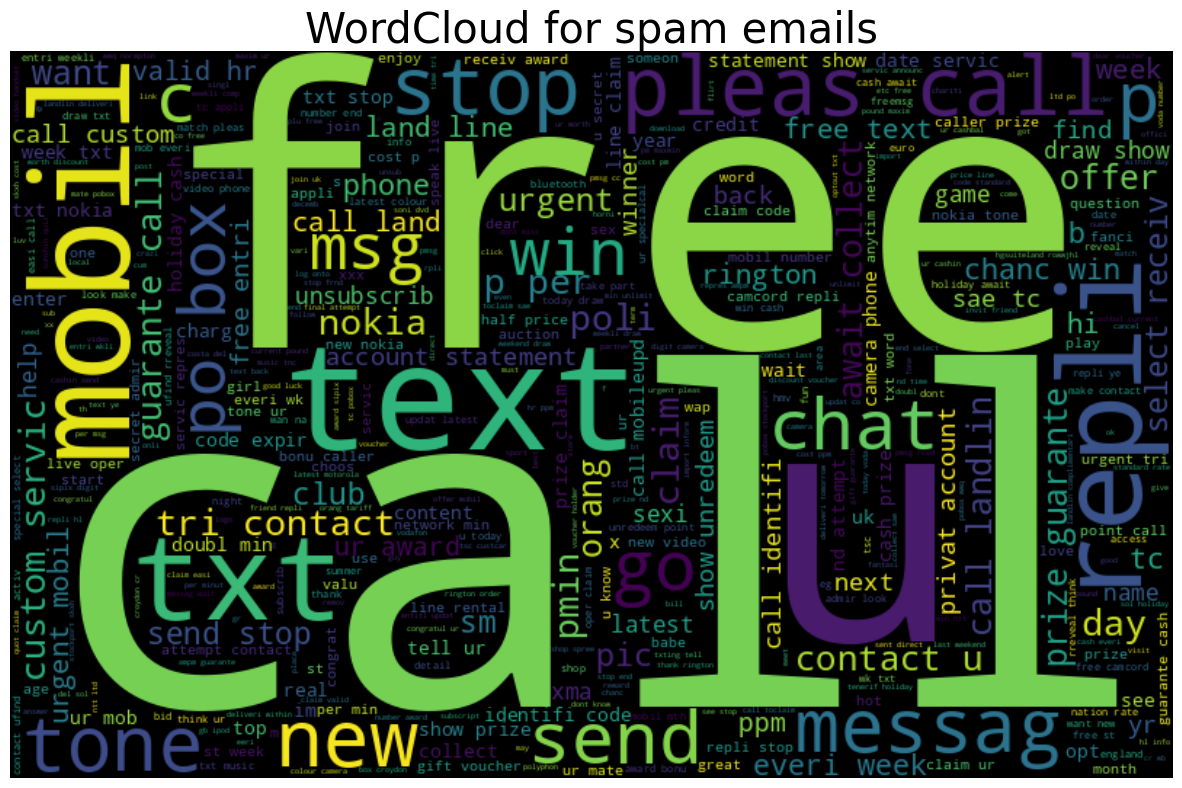

In [27]:
text = " ".join(data[data['Category'] == 'spam']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 500, width = 800,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('WordCloud for spam emails', fontsize=30)
plt.axis('off')
plt.show()

**frequent words in ham email**

In [28]:
all_spam_words = []
for sentence in data[data['Category'] == "ham"]['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
df = pd.DataFrame(Counter(all_spam_words).most_common(50), columns= ['Word', 'Frequency'])
df.style.background_gradient(cmap='Blues')

,Word,Frequency
0,u,177
1,im,68
2,ur,67
3,go,66
4,get,60
5,dont,54
6,ok,49
7,come,48
8,like,44
9,know,43


In [29]:
fig = px.treemap(df, path=['Word'], values='Frequency', title='Tree of Most Common Words', color='Word')
fig.show()

In [30]:
fig = px.bar(
    df,
    x="Frequency",
    y="Word",
    title='Most Common Negative Words',
    width=700,
    height=700,
    color='Frequency',  # Set the color based on the count of common words
    color_continuous_scale='YlOrRd',  # Choose the 'YlGnBu' color scale
)

fig.show()

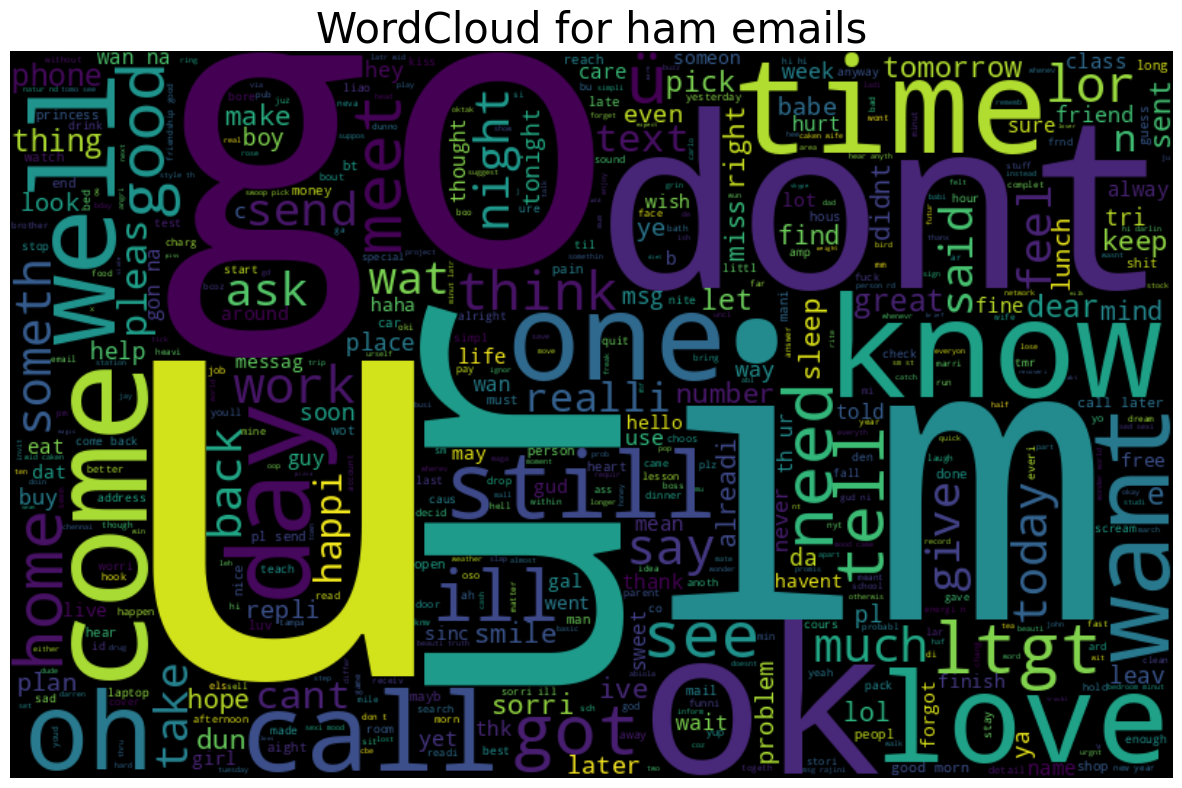

In [31]:
text = " ".join(data[data['Category'] == 'ham']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 500, width = 800,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('WordCloud for ham emails', fontsize=30)
plt.axis('off')
plt.show()

In [32]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(data.Message)

MAX_NB_WORDS = len(counter)
MAX_NB_WORDS

3259

In [33]:
data['Message_Length'] = data['Message'].apply(len)

In [34]:
MAX_LEN = data['Message_Length'].max()
MAX_LEN

398

In [35]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Message'].values)

In [36]:
word_index=tokenizer.word_index


In [37]:
import math

vocab_size = len(word_index)  # Assuming you have a word index from your dataset
embedding_dim = int(math.sqrt(vocab_size) / 2)  # Adjust the constant factor as needed

In [38]:
vocab_size

3259

In [39]:
embedding_dim

28

# **Modeling**

In [40]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
data['Category'] = labelencoder.fit_transform(data['Category'])
Y = data['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1494,)


In [41]:
X = tokenizer.texts_to_sequences(data['Message'].values)
X = pad_sequences(X, maxlen=MAX_LEN)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1494, 398)


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1045, 398) (1045,)
(449, 398) (449,)


In [43]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=30000,output_dim = 30, input_length=X_train.shape[1] ))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 398, 30)           900000    
                                                                 
 lstm (LSTM)                 (None, 398, 128)          81408     
                                                                 
 dropout (Dropout)           (None, 398, 128)          0         
                                                                 
 dense (Dense)               (None, 398, 128)          16512     
                                                                 
 dropout_1 (Dropout)         (None, 398, 128)          0         
                                                                 
 flatten (Flatten)           (None, 50944)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [45]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Train the model
epochs = 10
history=model.fit(X_train, Y_train ,validation_data=(X_test, Y_test),epochs=epochs,callbacks=[early_stop],verbose=2)

Epoch 1/10
33/33 - 24s - loss: 0.6662 - accuracy: 0.5818 - val_loss: 0.4956 - val_accuracy: 0.8085 - 24s/epoch - 719ms/step
Epoch 2/10
33/33 - 23s - loss: 0.2729 - accuracy: 0.9033 - val_loss: 0.1909 - val_accuracy: 0.9198 - 23s/epoch - 690ms/step
Epoch 3/10
33/33 - 19s - loss: 0.0897 - accuracy: 0.9703 - val_loss: 0.2046 - val_accuracy: 0.9532 - 19s/epoch - 590ms/step
Epoch 4/10
33/33 - 20s - loss: 0.2568 - accuracy: 0.9512 - val_loss: 0.1611 - val_accuracy: 0.9510 - 20s/epoch - 610ms/step
Epoch 5/10
33/33 - 22s - loss: 0.0719 - accuracy: 0.9818 - val_loss: 0.1337 - val_accuracy: 0.9577 - 22s/epoch - 667ms/step
Epoch 6/10
33/33 - 19s - loss: 0.0469 - accuracy: 0.9876 - val_loss: 0.1349 - val_accuracy: 0.9532 - 19s/epoch - 588ms/step
Epoch 7/10
33/33 - 23s - loss: 0.0315 - accuracy: 0.9914 - val_loss: 0.1430 - val_accuracy: 0.9510 - 23s/epoch - 693ms/step
Epoch 8/10
33/33 - 20s - loss: 0.0218 - accuracy: 0.9952 - val_loss: 0.1481 - val_accuracy: 0.9510 - 20s/epoch - 612ms/step


In [46]:
model.evaluate(X_test, Y_test)

15/15 [==============================] - 2s 155ms/step - loss: 0.1481 - accuracy: 0.9510


[0.14807641506195068, 0.9510022401809692]

In [47]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epoch = [i + 1 for i in range(len(train_acc))]

In [48]:
acc_loss_df = pd.DataFrame({"Training Loss" : train_loss,
                            "Validation Loss": val_loss,
                            "Train Accuracy" : train_acc,
                            "Validation Accuracy" : val_acc,
                            "Epoch":epoch})


acc_loss_df.style.bar()

,Training Loss,Validation Loss,Train Accuracy,Validation Accuracy,Epoch
0,0.666209,0.495639,0.581818,0.808463,1
1,0.272857,0.190916,0.903349,0.919822,2
2,0.089711,0.204592,0.970335,0.953229,3
3,0.256811,0.161085,0.951196,0.951002,4
4,0.071904,0.133726,0.981818,0.957684,5
5,0.046915,0.134888,0.987560,0.953229,6
6,0.031518,0.143000,0.991388,0.951002,7
7,0.021751,0.148076,0.995215,0.951002,8


In [49]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Train Accuracy'],
                         mode='lines+markers',
                         name='Training Accuracy'))

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Validation Accuracy'],
                         mode='lines+markers',
                         name = 'Validation Accuracy'))

fig.update_layout(title = {'text': "<b>Training Accuracy Vs Validation Accuracy</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Accuracy",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

In [50]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Training Loss'],
                         mode='lines+markers',
                         name='Training Loss'))

fig.add_trace(go.Scatter(x = acc_loss_df['Epoch'],
                         y = acc_loss_df['Validation Loss'],
                         mode='lines+markers',
                         name = 'Validation Loss'))

fig.update_layout(title = {'text': "<b>Training Loss Vs Validation Loss</b>\n",
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'y':0.9,'x':0.5,},
                  xaxis_title="Epoch",
                  yaxis_title = "Loss",
                  title_font = dict(size = 20))

fig.layout.template = 'plotly_dark'

fig.show()

In [51]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype("int32")

15/15 - 3s - 3s/epoch - 178ms/step


In [52]:
from sklearn.metrics import classification_report
target_names = ['spam','ham']
print(classification_report(Y_test, result, target_names=target_names))

              precision    recall  f1-score   support

        spam       0.94      0.96      0.95       217
         ham       0.96      0.94      0.95       232

    accuracy                           0.95       449
   macro avg       0.95      0.95      0.95       449
weighted avg       0.95      0.95      0.95       449



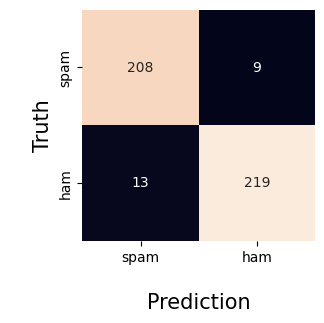

In [53]:
cm = confusion_matrix(Y_test,result)
classes = ['spam','ham']

plt.figure(figsize = (3,3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar=False).set(xticklabels = classes, yticklabels = classes)
plt.xlabel("\nPrediction", size = 15)
plt.ylabel("\nTruth",  size = 15)
plt.show()

In [54]:
testText="I‘m going to try for 2 months ha ha only joking"

In [55]:
predict_msg = ["	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"]

In [57]:
def predict_spam(predict_msg, threshold=0.5):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen=MAX_LEN)
    predictions = model.predict(padded)
    for pred in predictions:
        if pred > threshold:
            print("Spam")
        else:
            print("Ham")

# Example usage
predict_msg = ["Your free trail is going to end, renew it"]
predict_spam(predict_msg)


1/1 [==============================] - 0s 87ms/step
Ham
